# 1. Creating and training a VAE model for music
In this notebook we create the VAE model and train it. After training, we use the model to generate new music pieces. Before running this notebook, we have preprocessed the data as presented in

* `A_filter.ipynb`
* `B_map_instruments.ipynb`
* `C_slice_tracks.ipynb`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from IPython.display import Image
from IPython.core.display import Image, display
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from random import randint
import os 
import numpy as np
import pypianoroll as ppr
from PIL import Image as PIL_Image
from matplotlib import pyplot as plt
from matplotlib import gridspec as grid

device = torch.device('cuda')
cwd = os.getcwd()
print("Device:", device)

Device: cuda


## 1.1 Create data loaders
We create separate loaders for training and test data.

In [2]:
BATCH_SIZE = 32
train_root = os.path.join('.', 'train_data')
test_root  = os.path.join('.', 'test_data')
transform  = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])
train_set    = datasets.ImageFolder(root=train_root, transform = transform)
test_set     = datasets.ImageFolder(root=test_root,  transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
print("The training set contains " + str(len(train_set.imgs)) + " piano rolls.")
print("The test set contains " + str(len(test_set.imgs)) + " piano rolls.")

The training set contains 39268 piano rolls.
The test set contains 8376 piano rolls.


We can load one batch to see example piano rolls. Here plot a grid of 12 piano rolls from the training set. In each panel of the figure,
* the 8 leftmost columns correspond to drums
* the next 64 columns are bass
* the next 64 columns are piano
* the last 64 columns are the lead track (trumpet).

torch.Size([32, 1, 128, 200])


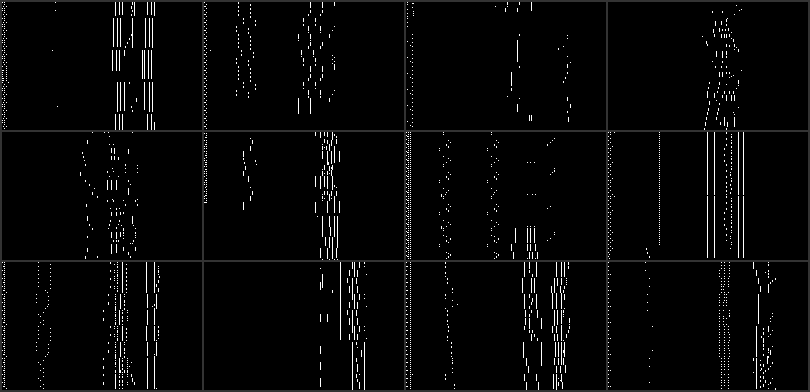

In [3]:
im, _ = next(iter(train_loader))
print(im.shape)
save_image(im[0:12,:,:,], 'training_examples.png', nrow = 4, pad_value = 0.2)
Image('training_examples.png')

## 1.2 Define model
We define a class that represents the VAE.

In [4]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 128*200))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

## 1.3 Training
The network dimensions and optimizer settings can be defined here.

In [5]:
D_LATENT = 16
vae = VAE(x_dim=128*200, h_dim1= 512, h_dim2=128, z_dim=D_LATENT)
vae.cuda()
optimizer = torch.optim.Adam(vae.parameters(), lr = 0.001)
print(vae)

VAE(
  (fc1): Linear(in_features=25600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc31): Linear(in_features=128, out_features=16, bias=True)
  (fc32): Linear(in_features=128, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=25600, bias=True)
)


Below we define functions for loss, training and testing.

In [6]:
# returns reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 128*200), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()       
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    mloss = train_loss / len(train_loader.dataset)
    print('Epoch: {}, Average training loss: {:.6f}'.format(epoch, mloss))
    return mloss

def test(epoch_idx):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            test_loss += loss_function(recon, data, mu, log_var).item()
            
    test_loss /= len(test_loader.dataset)
    print('Test set loss: {:.6f}'.format(test_loss))
    return test_loss
              
def save_model(epoch_idx):
    with torch.no_grad():
        filename = './pth/lin' + str(D_LATENT) + '/vae_' + str(epoch_idx).zfill(4) + '.pth'
        torch.save({'state_dict': vae.state_dict()}, filename)

Now we can run the training (takes long).

In [ ]:
os.mkdir('./pth/lin' + str(D_LATENT))
loss1 = np.zeros(1000)
loss2 = np.zeros(1000)
for epoch in range(1, 1000):
    loss1[epoch-1] = train(epoch)
    loss2[epoch-1] = test(epoch)
    if(epoch%100==0):
        save_model(epoch)

After training we visualize the training and test loss over the epochs.

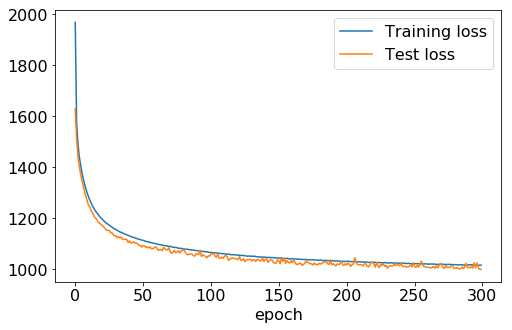

In [25]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 16})
plt.plot(loss1[0:300])
plt.plot(loss2[0:300])
plt.legend(['Training loss', 'Test loss'])
plt.xlabel('epoch')
plt.savefig('loss.png')
plt.show()

# 2. Generating new music
We can now use our trained model to create new 'songs' by drawing random samples from the latent prior and decoding them.

## 2.1 Load trained model

In [7]:
checkpoint = torch.load('pth/lin16/vae_0300.pth')
vae.load_state_dict(checkpoint['state_dict'])
vae.eval()
for name, param in vae.named_parameters():
    if param.requires_grad:
        print("Param name:", name, ", Size =", param.data.shape)

Param name: fc1.weight , Size = torch.Size([512, 25600])
Param name: fc1.bias , Size = torch.Size([512])
Param name: fc2.weight , Size = torch.Size([128, 512])
Param name: fc2.bias , Size = torch.Size([128])
Param name: fc31.weight , Size = torch.Size([16, 128])
Param name: fc31.bias , Size = torch.Size([16])
Param name: fc32.weight , Size = torch.Size([16, 128])
Param name: fc32.bias , Size = torch.Size([16])
Param name: fc4.weight , Size = torch.Size([128, 16])
Param name: fc4.bias , Size = torch.Size([128])
Param name: fc5.weight , Size = torch.Size([512, 128])
Param name: fc5.bias , Size = torch.Size([512])
Param name: fc6.weight , Size = torch.Size([25600, 512])
Param name: fc6.bias , Size = torch.Size([25600])


## 2.2 Draw and decode new samples

Define functions for drawing samples, decoding and saving as MIDI.

In [8]:
def decode_numpy(arr):
    with torch.no_grad():
        z = torch.from_numpy(arr).float().to(device)
        sample = vae.decoder(z)
        smp = sample.view(128, 200).cpu().data.numpy()
        return(smp)
        
def random_numpy():
    with torch.no_grad():
        z = torch.randn(1, D_LATENT).cuda()
        sample = vae.decoder(z).cuda()
        smp = sample.view(128, 200).cpu().data.numpy()
        return(smp)
    
def binarize(track, threshold):
    track = 100*(track>threshold).astype('int')
    return(track)

def numpy_to_tracks(a, THRESHOLDS, use_tresh = True):
    piano = np.zeros((128, 128))
    bass  = np.zeros((128, 128))
    lead  = np.zeros((128, 128))
    drum  = np.zeros((128, 128))
    piano[:, 16:(16+64)]               = a[:,(8+64):(8+2*64)]
    bass[:, 0:64]                      = a[:,8:(8+64)]
    lead[:, 48:(48+64)]                = a[:,(8+2*64):(8+3*64)]
    drum[:, (35,38,42,43,46,47,49,51)] = a[:,0:8]
    if(use_tresh):
        piano = binarize(piano, THRESHOLDS[0])
        bass = binarize(bass, THRESHOLDS[1])
        lead = binarize(lead, THRESHOLDS[2])
        drum = binarize(drum, THRESHOLDS[3])
        
    t0 = ppr.Track(pianoroll=piano, program=0, is_drum=False, name='piano')
    t1 = ppr.Track(pianoroll=bass, program=34, is_drum=False, name='bass')
    t2 = ppr.Track(pianoroll=lead, program=56, is_drum=False, name='lead')
    t3 = ppr.Track(pianoroll=drum, program=0, is_drum=True, name='drums')
    multitrack = ppr.Multitrack(tracks=[t2,t0,t1,t3], tempo=120.0,
                        downbeat=[0, 32, 64, 96], beat_resolution=4)
    return(multitrack)

def generate_random_tracks(h, binarize):
    #arr = np.random.normal(size=(1, D_LATENT))
    smp = random_numpy()
    trk = numpy_to_tracks(smp, h, binarize)
    return(trk)

def generate_random(filename, thresholds = 0.5*np.ones(4), verbose = True, binarize = True):
    trk = generate_random_tracks(thresholds, binarize)
    visualize(trk, filename)
    if verbose:
        print('Writing', filename)
    trk.write(filename)

def get_pianoroll(track):
    if(track.name=='piano'):
        i1 = 16
        i2 = 16+64
    elif(track.name=='bass'):
        i1 = 0
        i2 = 64
    else:
        i1 = 48
        i2 = 48+64
    mat = track.pianoroll[:, i1:i2]
    return(mat)
    
def get_drumroll(track):
    mat = track.pianoroll[:,(35,38,42,43,46,47,49,51)]
    return(mat)

def visualize(trk, fn, show = False, save = True):
    p = fn
    p = p[0:(len(p)-4)]
    p = p + '.png'

    t0 = get_pianoroll(trk.tracks[0])
    t1 = get_pianoroll(trk.tracks[1])
    t2 = get_pianoroll(trk.tracks[2])
    t3 = get_drumroll(trk.tracks[3])
    grid.GridSpec(2,2)
    fig = plt.figure(figsize=(10,4.5))
    plt.rcParams.update({'font.size': 12})

    # Plot lead
    plt.subplot2grid((1,4), (0,0))
    plt.imshow(t0, aspect = 'auto', cmap = 'Greens')
    plt.title('Lead')
    plt.ylabel('Time step')
    plt.xlabel('Note')
    plt.xticks([0,12,24,36,48,60], ['C3', 'C4', 'C5', 'C6', 'C7', 'C8'])
    
    # Plot piano
    plt.subplot2grid((1,4), (0,1))
    plt.imshow(t1, aspect = 'auto', cmap = 'Reds')
    plt.title('Piano')
    plt.xlabel('Note')
    plt.xticks([0,12,24,36,48,60], ['E1', 'E2', 'E3', 'E4', 'E5', 'E6'])
    
    # Plot bass
    plt.subplot2grid((1,4), (0,2))
    plt.imshow(t2, aspect = 'auto', cmap = 'Blues')
    plt.title('Bass')
    plt.xlabel('Note')
    plt.xticks([0,12,24,36,48,60], ['C-1', 'C0', 'C1', 'C2', 'C3', 'C4'])
    
    # Plot drums
    plt.subplot2grid((1,4), (0,3))
    plt.imshow(t3, aspect = 'auto', cmap = 'Greys')
    plt.title('Drums')
    plt.xticks([0,1,2,3,4,5,6,7,8], ['kick', 'snare',' closed hat',  'low tom', 'open hat', 'high tom', 'crash', 'ride'],
              rotation='vertical')
    
    fig.tight_layout()
    if save:
        fig.savefig(p)
        
    if show:
        plt.show()
    else:
        plt.close()

Here we generate 100 samples.

In [ ]:
THRESHOLDS = [0.3, 0.3, 0.6, 0.3]
for i in range(0,100):
    fn = 'samples/random_' + str(i).zfill(3) + '.mid'
    generate_random(fn, THRESHOLDS, binarize = True)

# 3. Reconstruction
Here we study what the typical reconstructions look and sound like.

In [9]:
def file_to_numpy(fn):
    img = PIL_Image.open(fn).convert('L')
    a = np.array(img)
    a = a/255
    return(a)

def recon(idx_song, idx_sample = 1, is_test = False):
    if(idx_song > 1000):
        idx_song -= 1 # correct for indexing error due to failed load earlier
    str0 = 'train_data'
    if(is_test):
        str0 = 'test_data'
    str1 = str(idx_song).zfill(4)
    str2 = str(idx_sample).zfill(4)
    data_path = os.path.join('.', str0, 'img' + str1, 'img' + str1 + '__' + str2 + '.png')
    arr = file_to_numpy(data_path)
    vae.eval()
    with torch.no_grad():
        data = torch.from_numpy(arr).float().to(device)
        data = data.view(1,1,128,200)
        rec, mu, log_var = vae(data)
        rec = rec.view(-1,128,200)[0,:,:].cpu().data.numpy()
        dat = data[0,0,:,:].cpu().data.numpy()
        return(rec, dat)
            

## 3.1 Reconstructing samples from the training set
We reconstruct a parts of the song 133, which is *All The Small Things (1999)* by Blink-128.

In [13]:
song_idx = 133
for sample_idx in range(2,5):
    rec, dat = recon(song_idx, sample_idx) 
    THRESHOLDS = [0.3, 0.3, 0.6, 0.3]
    trk0 = numpy_to_tracks(rec, THRESHOLDS, use_tresh = False)
    trk1 = numpy_to_tracks(rec, THRESHOLDS, use_tresh = True)
    trk2 = numpy_to_tracks(dat, THRESHOLDS)
    
    # Write to midi
    fend = str(song_idx) + '_' + str(sample_idx)
    trk1.write('recon/rec' + fend + '.mid')
    trk2.write('recon/dat' + fend + '.mid')

    # We plot first the reconstruction, then binarized reconstruction and then the original data
    visualize(trk0, 'recon/rec' + fend + '.png')
    visualize(trk1, 'recon/bin' + fend + '.png')
    visualize(trk2, 'recon/dat' + fend + '.png')

## 3.2 Reconstructing samples from the test set
We reconstruct a parts of the song 4603, which is *Up Around The Bend (1970)* by Creedence Clearwater Revival.

In [14]:
song_idx = 4603
for sample_idx in range(4,8):
    rec, dat = recon(song_idx, sample_idx, is_test = True) 
    THRESHOLDS = [0.3, 0.3, 0.3, 0.3]
    trk0 = numpy_to_tracks(rec, THRESHOLDS, use_tresh = False)
    trk1 = numpy_to_tracks(rec, THRESHOLDS, use_tresh = True)
    trk2 = numpy_to_tracks(dat, THRESHOLDS)
    
    # Write to midi
    fend = str(song_idx) + '_' + str(sample_idx)
    trk1.write('recon/rec' + fend + '.mid')
    trk2.write('recon/dat' + fend + '.mid')

    # We plot first the reconstruction, then binarized reconstruction and then the original data
    visualize(trk0, 'recon/rec' + fend + '.png')
    visualize(trk1, 'recon/bin' + fend + '.png')
    visualize(trk2, 'recon/dat' + fend + '.png')